In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user lazypredict

In [3]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Base packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import string as st
%matplotlib inline

# Helper packages
import time
import os
import pickle
import re

# Preprocessing packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Machine Learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Scoring packages
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

## Tokenizer helper function

Function which helps preserve special characters during tokenization

In [5]:
def tokenizer(x):
    r='!"#$%&;()*+,-./:;<=>?\'@[\\]^_`{|}~'
    to_replace=[re.escape(i) for i in r]

    replace_with=[' '+i+' ' for i in r]
    x=x.lower()
    x=pd.DataFrame([x])[0].replace(to_replace,replace_with,regex=True)[0]
    return(x)
 
corpus=pd.DataFrame(["That's an example.",
"Don't ignore it!",
"This is another example.",
"50$ is a price:-) !&!!^)",
"Look @predictivehacks for more hacks",
"These are hashtags #predictivehacks #datascience #100%fun"],columns=['sentences'])



In [6]:
# Keeps punctuation and seperates a space
corpus["sentences"].apply(tokenizer)

0                               that ' s an example . 
1                                 don ' t ignore it ! 
2                           this is another example . 
3         50 $  is a price :  -  )   !  &  !  !  ^  ) 
4               look  @ predictivehacks for more hacks
5    these are hashtags  # predictivehacks  # datas...
Name: sentences, dtype: object

In [7]:
#We are using the '\S+' as token pattern so it will create tokens 
#splitting with one or more spaces
 
v = CountVectorizer(token_pattern='\S+')
x = v.fit_transform(corpus['sentences'].apply(tokenizer))

In [8]:
f = pd.DataFrame(x.toarray()) 
f.columns=v.get_feature_names()
 
f=f.sum(axis=0)
 
print(f)

!                  4
#                  3
$                  1
%                  1
&                  1
'                  2
)                  2
-                  1
.                  2
100                1
50                 1
:                  1
@                  1
^                  1
a                  1
an                 1
another            1
are                1
datascience        1
don                1
example            2
for                1
fun                1
hacks              1
hashtags           1
ignore             1
is                 2
it                 1
look               1
more               1
predictivehacks    2
price              1
s                  1
t                  1
that               1
these              1
this               1
dtype: int64


In [9]:
# Used for testing standardisation 
seed = 170280378

In [10]:
os.getcwd()

'C:\\Users\\User\\Desktop\\PROJECT WORK\\Jupyter Repo'

In [11]:
# UTF-16 as some characters can't be read with UTF-8
df = pd.read_csv("SQLi/SQLi_train_valid.csv", encoding="UTF-16")

In [12]:
# Quick inspection
df.head()

,Sentence,Label
0,NaN,1
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33761 entries, 0 to 33760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  33757 non-null  object
 1   Label     33761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 527.6+ KB


In [14]:
# showing missing values
print(df.isna().sum())
df[df.isna().any(axis=1)]

Sentence    4
Label       0
dtype: int64


,Sentence,Label
0,NaN,1
951,NaN,0
3953,NaN,1
3995,NaN,1


In [15]:
# Remove missing values

df.dropna(axis=0, inplace=True)

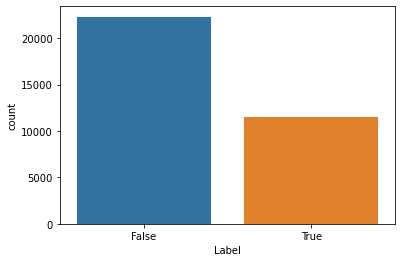

In [16]:
sns.countplot(df["Label"]==1)

In [17]:
# We can see that 33% sentences test positive for SQL injection, we can use this as one benchmark to beat.
(df["Label"] == 1).sum() / len(df["Label"])

0.339277779423527


### CountVectorizer
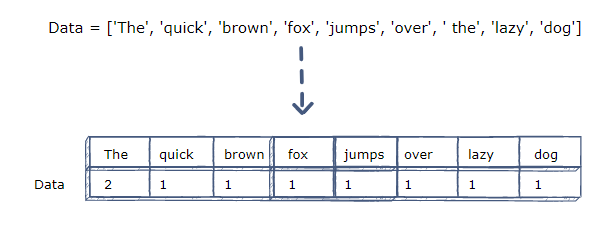

### Common hyperparameters

- min and max_df, ignore terms that have a frequency below or above a certain threshold. Default is 1 so no terms ignored.
- stop_words: Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. 

In [18]:
# However, we can see that the stop word "and" is also used in SQL comments, have to test this because unsure of the relationship
df[df["Sentence"].str.contains("and")]

,Sentence,Label
29,1 and ascii ( lower ( substring ( ( select ...,1
72,or 2 between 1 and 3,1
105,1 and user_name ( ) = 'dbo',1
198,and 1 in ( select var from temp ) --,1
221,1 and 1 = 1,1
...,...,...
33374,andras,0
33423,ferreres perandrs,0
33572,llanderal campos,0
33631,gandolfo,0


In [19]:
# punctuation also features prominently
df[df["Sentence"].str.contains("'")]

,Sentence,Label
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
5,select * from users where id = '1' or @ @1 = ...,1
7,' select name from syscolumns where id = ( ...,1
10,select * from users where id = '1' or ||/1 = ...,1
11,select * from users where id = '1' or \.<\ un...,1
...,...,...
31198,"aldea, l'",0
31418,mc'morral obrist,0
31763,bellcaire d'empord,0
31809,"partida lliriet d'en mig, 135, 10?a",0


# Reducing here as the dataframe is just too big
Standardise at 10, 000 rows total


In [20]:
df["Label"]

1        1
2        1
3        1
4        1
5        1
        ..
33756    0
33757    0
33758    0
33759    0
33760    0
Name: Label, Length: 33757, dtype: int64

In [21]:
# This reduces to roughly 8000 rows
df = df.groupby('Label').apply(pd.DataFrame.sample, frac=0.23698).reset_index(drop=True)

In [22]:
df["Sentence"] = df["Sentence"].apply(tokenizer)

In [23]:
# Still preserves the same ratio of values
(df["Label"] == 1).sum() / len(df["Label"])

0.33925

In [24]:
df

,Sentence,Label
0,steelsmith @ 7peines . com,0
1,pente @ maxitienda . ms,0
2,lncara,0
3,4364,0
4,overdyke,0
...,...,...
7995,"1 "" ) where 7578 = 7578 and 6414 = (...",1
7996,- 3873 % ' ) ) or 1 group by concat...,1
7997,1 ' and 5556 = ( select count ( * )...,1
7998,"1 "" ) where 5794 = 5794 union all select...",1


In [25]:
X_train=df["Sentence"]

In [26]:
y_train=df["Label"]

In [27]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
7995    1
7996    1
7997    1
7998    1
7999    1
Name: Label, Length: 8000, dtype: int64

In [28]:
# We need to split into train and test data
# The default method is to use train_test_split as taught in NN class
# One concept is k-folds CV (splitting into k subsets and train/testing on each subset)
# Another one is stratification, in which each subset will contain roughly and proportional representation of 0 and 1 target value
# I.e., when split, each fold should contain roughly 27% positive target values
# For this approach, we will opt for StratifiedKFold which is a good middle ground
# Don't need to include shuffle 

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=seed)

In [29]:
# Begin with vectorization, don't bother with hyperparameters for now? Scope too wide?
# Fit and transform ONLY training, ONLY transform validation and test
cv = CountVectorizer(token_pattern="\S+")
tfv = TfidfVectorizer(token_pattern="\S+")


In [30]:
count_vect_train = cv.fit_transform(X_train)
tf_vect_train = tfv.fit_transform(X_train)

In [31]:
#count_vect_val = cv.transform(X)
#tf_vect_val = tfv.transform(X)

In [32]:
X_train = pd.DataFrame(count_vect_train.toarray())

In [33]:
# X_val = pd.DataFrame(count_vect_val.toarray())

# Hyperparameter tuning


## Example of how steps can be chained

Not done for debugging and scope reasons

In [34]:
# Save the cv object for later use
cv_pickle = "sqli_cv_pickle.sav"
pickle.dump(cv, open(cv_pickle, "wb"))

In [35]:
time_taken = []

### Decision Tree

In [36]:
train_recall_score = []

In [37]:
decision_tree = DecisionTreeClassifier(random_state=seed)

In [38]:
dt_parameters = {'max_features': ['log2', 'sqrt','auto', None], 
              'criterion': ['entropy', 'gini'],
                 'splitter':['best', 'random'],
                'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 5, 10],
              'min_samples_leaf': [2, 3, 5, 10]
             }

In [39]:

best_dt = RandomizedSearchCV(decision_tree, dt_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
dt_start = time.time()
best_dt.fit(X_train, y_train)
dt_end = time.time()
dt_time_taken = (dt_end-dt_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=0.000, total=   0.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=0.000, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_feature

[CV]  splitter=best, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, criterion=gini, score=0.650, total=   0.6s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   18.5s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.839, total=   0.6s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   19.2s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.611, total=   0.6s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   19.9s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=b

[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=2, criterion=entropy, score=0.042, total=   0.7s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


In [40]:
print(dt_time_taken)

3.1711742210388185


In [41]:
time_taken.append(dt_time_taken)

In [42]:
best_dt.best_params_

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 50,
 'criterion': 'entropy'}

In [43]:
dt_pickle = "sqli_dt_pickle.sav"
pickle.dump(best_dt, open(dt_pickle, "wb"))

In [44]:
dt_recall = best_dt.best_score_

In [45]:
dt_recall

0.990418815790368

In [46]:
train_recall_score.append(dt_recall)

In [47]:
train_recall_score

[0.990418815790368]

### Random Forest

In [48]:
random_forest = RandomForestClassifier(random_state=seed)

In [49]:
rf_parameters = {"n_estimators":[10, 50, 100],
                 "max_features":["log2", "sqrt", "auto", None],
                 "criterion":["entropy", "gini"],
                 "max_depth":[2, 3, 5, 10, 50],
                 "min_samples_split":[2, 3, 5],
                 "min_samples_leaf":[2, 3, 5]
}

In [50]:
best_rf = RandomizedSearchCV(random_forest, rf_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
rf_start = time.time()
best_rf.fit(X_train, y_train)
rf_end = time.time()
rf_time_taken = (rf_end-rf_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=0.000, total=   0.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=0.000, total=   0.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2

[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, score=0.685, total=   0.9s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 43.0min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.362, total=   2.9s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 43.0min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.355, total=   3.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 43.1min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV] 

[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=2, criterion=entropy, score=0.954, total= 2.4min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 85.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 85.6min finished


In [51]:
print(rf_time_taken)

113.4709722185135


In [52]:
time_taken.append(rf_time_taken)

In [53]:
best_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': None,
 'max_depth': 10,
 'criterion': 'entropy'}

In [54]:
rf_pickle = "sqli_rf_pickle.sav"
pickle.dump(best_rf, open(rf_pickle, "wb"))


In [55]:
rf_recall = best_rf.best_score_

In [56]:
train_recall_score.append(rf_recall)

In [57]:
train_recall_score

[0.990418815790368, 0.9911554640408282]

### SVC

In [58]:
svc = SVC(random_state=seed)

In [59]:
svc_parameters = {"kernel": ["linear", "rbf", "poly"],
                 "gamma": [0.1, 1, 10, 100],
                 "C": [0.1, 1, 10, 100, 1000],
                  "degree": [0, 1, 2, 3, 4, 5, 6]
}

In [60]:
best_svc = RandomizedSearchCV(svc, svc_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
svc_start = time.time()
best_svc.fit(X_train, y_train)
svc_end = time.time()
svc_time_taken = (svc_end-svc_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.982, total= 6.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.994, total= 6.7min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.5min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.985, total= 7.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.5min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=0.991, total= 7.7min
[Parallel(n_jobs=1)]: Done   4

[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.000, total= 9.6min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 379.9min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.000, total=10.7min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 390.6min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.000, total=11.3min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 401.9min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.000, total=11.3min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 413.2min remaining:    0.0s
[CV] kernel=rbf, gamma=100, degree=4, C=0.1 ..........................
[CV]  kernel=rbf, gamma=100, degree=4, C=0.1, score=0.000, total=16.0min
[Parallel(n_jobs=1)]: Done  41 out 

In [61]:
print(svc_time_taken)

657.6228152370453


In [62]:
time_taken.append(svc_time_taken)

In [63]:
svc_pickle = "sqli_svc_pickle.sav"
pickle.dump(best_svc, open(svc_pickle, "wb"))


In [64]:
best_svc.best_params_

{'kernel': 'poly', 'gamma': 100, 'degree': 1, 'C': 0.1}

In [65]:
svc_recall = best_svc.best_score_

In [66]:
train_recall_score.append(svc_recall)

In [67]:
train_recall_score

[0.990418815790368, 0.9911554640408282, 0.9904174566607544]

## Logistic REgression

In [68]:
lr = LogisticRegression(random_state=seed)

In [69]:
lr_parameters = {
     'penalty' : ["l2", None],
    'C' : [0.1, 1.0, 10, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter":[5, 10, 25, 50, 75, 100],
    "multi_class": ["auto", "ovr", "multinomial"]
}

In [70]:
best_lr = RandomizedSearchCV(lr, lr_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
lr_start = time.time()
best_lr.fit(X_train, y_train)
lr_end = time.time()
lr_time_taken = (lr_end-lr_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, 

[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 12.0min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.3s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 12.0min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 12.0min remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0, score=nan, total=   0.6s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 12.0min remaining:    0.0s
[

In [71]:
print(lr_time_taken)

16.69295042037964


In [72]:
time_taken.append(lr_time_taken)

In [73]:
best_lr.best_params_

{'solver': 'saga',
 'penalty': 'l2',
 'multi_class': 'auto',
 'max_iter': 100,
 'C': 10}

In [74]:
lr_pickle = "sqli_lr_pickle.sav"
pickle.dump(best_lr, open(lr_pickle, "wb"))

In [75]:
lr_recall = best_lr.best_score_

In [76]:
lr_recall

0.9841525487078074

In [77]:
train_recall_score.append(lr_recall)

In [78]:
train_recall_score

[0.990418815790368, 0.9911554640408282, 0.9904174566607544, 0.9841525487078074]

## KNeighbours

In [79]:
knn = KNeighborsClassifier()

In [80]:
knn_parameters = {"n_neighbors": [1, 5, 10, 25, 50, 75, 100],
                  "weights": ["uniform", "distance"],
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                  "leaf_size": [1, 5, 10, 20, 30, 35, 50]
    
}

In [81]:
best_knn = RandomizedSearchCV(knn, knn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
knn_start = time.time()
best_knn.fit(X_train, y_train)
knn_end = time.time()
knn_time_taken = (knn_end-knn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.845, total= 3.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.832, total= 3.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.834, total= 3.2min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=un

[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.849, total= 3.4min
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 71.2min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.851, total= 3.4min
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 74.6min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.875, total= 3.4min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 78.0min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree, score=0.858, total= 7.3min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 85.2min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  w

In [82]:
print(knn_time_taken)

172.78027426719666


In [83]:
time_taken.append(knn_time_taken)

In [84]:
best_knn.best_params_

{'weights': 'distance',
 'n_neighbors': 1,
 'leaf_size': 5,
 'algorithm': 'kd_tree'}

In [85]:
knn_pickle = "sqli_knn_pickle.sav"
pickle.dump(best_knn, open(knn_pickle, "wb"))

In [86]:
knn_recall = best_knn.best_score_

In [87]:
knn_recall

0.9554137530325579

In [88]:
train_recall_score.append(knn_recall)

In [89]:
train_recall_score

[0.990418815790368,
 0.9911554640408282,
 0.9904174566607544,
 0.9841525487078074,
 0.9554137530325579]

## Multinomial NB

Special case with few hyperparameters to tune (Reduced)

In [90]:
nb = MultinomialNB()

In [91]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [92]:
nb_parameters = {"alpha": [0, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  "class_prior": [None],
                  "fit_prior": [True, False]
    
}

In [93]:
best_nb = RandomizedSearchCV(nb, nb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
nb_start = time.time()
best_nb.fit(X_train, y_train)
nb_end = time.time()
nb_time_taken = (nb_end-nb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.993, total=   2.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.998, total=   2.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.996, total=   2.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.993, total=   2.2s
[Parallel(

[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.994, total=   2.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.3min remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.998, total=   2.2s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  1.4min remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.998, total=   2.2s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  1.4min remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.998, total=   2.2s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.5min remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.996, total=   2.1s
[Paral

In [94]:
print(nb_time_taken)

2.29656822681427


In [95]:
time_taken.append(nb_time_taken)

In [96]:
best_nb.best_params_

{'fit_prior': False, 'class_prior': None, 'alpha': 10}

In [97]:
nb_pickle = "sqli_nb_pickle.sav"
pickle.dump(best_nb, open(nb_pickle, "wb"))

In [98]:
nb_recall = best_nb.best_score_

In [99]:
nb_recall

0.9970513683037382

In [100]:
train_recall_score.append(nb_recall)

In [101]:
train_recall_score

[0.990418815790368,
 0.9911554640408282,
 0.9904174566607544,
 0.9841525487078074,
 0.9554137530325579,
 0.9970513683037382]

## MLPClassifier

In [102]:
nn = MLPClassifier(random_state=seed)

In [103]:
nn.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [104]:
nn_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ["identity", "logistic", "tanh", "relu"],
    'solver': ['sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive', "invscaling"],
    "learning_rate_init": [0.001, 0.01]
}
    


In [105]:
best_nn = RandomizedSearchCV(nn, nn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
nn_start = time.time()
best_nn.fit(X_train, y_train)
nn_end = time.time()
nn_time_taken = (nn_end-nn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=0.982, total= 4.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=0.989, total= 4.6min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50

[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.956, total= 9.1min
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 77.8min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.956, total= 8.8min
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 86.7min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.967, total= 8.5min
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 95.1min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=

[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.985, total= 1.9min
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 125.7min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.993, total=  51.7s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 126.6min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=0.993, total= 1.8min
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 128.4min remaining:    0.0s
[CV

In [106]:
print(nn_time_taken)

160.35192840099336


In [107]:
time_taken.append(nn_time_taken)

In [108]:
best_nn.best_params_

{'solver': 'adam',
 'learning_rate_init': 0.01,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (50, 100, 50),
 'alpha': 0.1,
 'activation': 'tanh'}

In [109]:
nn_pickle = "sqli_nn_pickle.sav"
pickle.dump(best_nn, open(nn_pickle, "wb"))

In [110]:
nn_recall = best_nn.best_score_

In [111]:
nn_recall

0.9929984437965927

In [112]:
train_recall_score.append(nn_recall)

In [113]:
train_recall_score

[0.990418815790368,
 0.9911554640408282,
 0.9904174566607544,
 0.9841525487078074,
 0.9554137530325579,
 0.9970513683037382,
 0.9929984437965927]

## XGBClassifier

In [114]:
xgb = XGBClassifier(random_state=seed)

In [115]:
xgb.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [116]:
xgb_parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
}
    


In [117]:
best_xgb = RandomizedSearchCV(xgb, xgb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="recall")
xgb_start = time.time()
best_xgb.fit(X_train, y_train)
xgb_end = time.time()
xgb_time_taken = (xgb_end-xgb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.982, total=  32.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.993, total=  32.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=0.989, total=  31.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[CV] subsample=0.8, min_child_

[CV]  subsample=0.8, min_child_weight=10, max_depth=4, gamma=5, colsample_bytree=0.8, score=0.989, total=  42.1s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.6min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.982, total=  32.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 24.1min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.991, total=  34.4s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 24.7min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.987, total=  33.7s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 25.3mi

In [118]:
print(xgb_time_taken)

46.580467767715454


In [119]:
time_taken.append(xgb_time_taken)

In [120]:
best_xgb.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [121]:
xgb_pickle = "sqli_xgb_pickle.sav"
pickle.dump(best_xgb, open(xgb_pickle, "wb"))

In [122]:
xgb_recall = best_xgb.best_score_

In [123]:
xgb_recall

0.9911554640408282

In [124]:
train_recall_score.append(xgb_recall)

In [125]:
train_recall_score

[0.990418815790368,
 0.9911554640408282,
 0.9904174566607544,
 0.9841525487078074,
 0.9554137530325579,
 0.9970513683037382,
 0.9929984437965927,
 0.9911554640408282]

# Load in test data

In [126]:
# UTF-16 as some characters can't be read with UTF-8
test_df = pd.read_csv("SQLi/SQLi_test.csv", encoding="UTF-16")

In [127]:
# Quick inspection
test_df.head()

,Sentence,Label
0,a,1
1,a',1
2,a' --,1
3,a' or 1 = 1; --,1
4,@,1


In [128]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4187 non-null   object
 1   Label     4200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.8+ KB


In [129]:
# showing missing values
print(test_df.isna().sum())
test_df[test_df.isna().any(axis=1)]

Sentence    13
Label        0
dtype: int64


,Sentence,Label
1127,NaN,1
1531,NaN,0
1532,NaN,0
2314,NaN,0
2315,NaN,0
3034,NaN,0
3288,NaN,0
3289,NaN,0
3328,NaN,0
3329,NaN,0


In [130]:
# Remove missing values

test_df.dropna(axis=0, inplace=True)

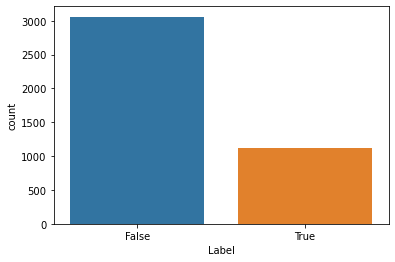

In [131]:
# Dataset is more inbalanced
sns.countplot(test_df["Label"]==1)

In [132]:
# Different allocation of label values
(test_df["Label"] == 1).sum() / len(test_df["Label"])

0.2691664676379269

In [133]:
test_df["Label"]

0       1
1       1
2       1
3       1
4       1
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: Label, Length: 4187, dtype: int64

In [134]:
test_df = test_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.47766).reset_index(drop=True)

In [135]:
test_df["Sentence"] = test_df["Sentence"].apply(tokenizer)

In [136]:
# Still preserves the same ratio of values
(test_df["Label"] == 1).sum() / len(test_df["Label"])

0.269

In [137]:
# Vectorize with the same CountVectorizer (important)

test_count_vect = cv.transform((test_df["Sentence"]))

In [138]:
X_test = pd.DataFrame(test_count_vect.toarray())

In [139]:
y_test = test_df["Label"]

In [140]:
time_taken

[3.1711742210388185,
 113.4709722185135,
 657.6228152370453,
 16.69295042037964,
 172.78027426719666,
 2.29656822681427,
 160.35192840099336,
 46.580467767715454]

In [141]:
train_recall_score

[0.990418815790368,
 0.9911554640408282,
 0.9904174566607544,
 0.9841525487078074,
 0.9554137530325579,
 0.9970513683037382,
 0.9929984437965927,
 0.9911554640408282]

In [142]:
test_recall_scores = []
prediction_time = []

In [143]:
classifiers = [best_dt, best_rf, best_svc, best_lr, best_knn, best_nb, best_nn, best_xgb]

In [144]:
for i in classifiers:
    start = time.time()
    y_test_pred = i.predict(X_test)
    end = time.time()
    prediction_time.append(end-start)
    test_recall_score = recall_score(y_test, y_test_pred)
    test_recall_scores.append(test_recall_score)

In [145]:
test_recall_scores

[0.8587360594795539,
 0.8401486988847584,
 0.8996282527881041,
 0.8011152416356877,
 0.929368029739777,
 0.9200743494423792,
 0.8866171003717472,
 0.8438661710037175]

In [146]:
results =   {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
        "Training/Validation Recall": train_recall_score,
        "Testing Recall": test_recall_scores
       }
  



In [147]:
prediction_time

[0.18849539756774902,
 0.15658283233642578,
 125.46018052101135,
 0.13866209983825684,
 277.67199659347534,
 0.21941375732421875,
 0.19245028495788574,
 0.6941430568695068]

In [148]:
time_taken

[3.1711742210388185,
 113.4709722185135,
 657.6228152370453,
 16.69295042037964,
 172.78027426719666,
 2.29656822681427,
 160.35192840099336,
 46.580467767715454]

In [149]:
times = {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
         
         "Average training time" : time_taken,
         "Prediction time": prediction_time
            

       
}

In [150]:
results_df = pd.DataFrame(results)

In [151]:
results_df

,Algorithm,Training/Validation Recall,Testing Recall
0,Decision Tree,0.99,0.86
1,Random Forest,0.99,0.84
2,Support Vector Machine,0.99,0.90
3,Logistic Regression,0.98,0.80
4,K Nearest Neighbours,0.96,0.93
5,Naive Bayes,1.00,0.92
6,Neural Network,0.99,0.89
7,XGBoost,0.99,0.84


In [152]:
results_df.to_pickle("SQLi Results Pickle")

In [153]:
results_df.sort_values(by="Training/Validation Recall", inplace=True)

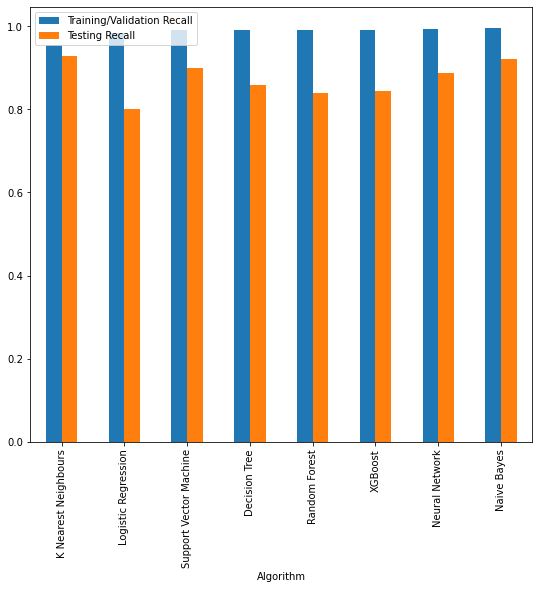

In [154]:
results_df.plot(x="Algorithm", y=["Training/Validation Recall", "Testing Recall"], kind="bar", figsize=(9,8))

In [155]:
results_df.sort_values(by="Testing Recall", inplace=True)

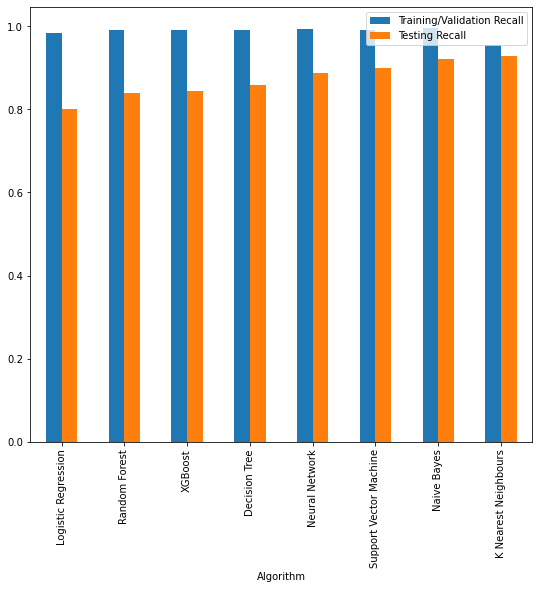

In [156]:
results_df.plot(x="Algorithm", y=["Training/Validation Recall", "Testing Recall"], kind="bar", figsize=(9,8))

In [157]:
time_df = pd.DataFrame(times)

In [158]:
time_df

,Algorithm,Average training time,Prediction time
0,Decision Tree,3.17,0.19
1,Random Forest,113.47,0.16
2,Support Vector Machine,657.62,125.46
3,Logistic Regression,16.69,0.14
4,K Nearest Neighbours,172.78,277.67
5,Naive Bayes,2.30,0.22
6,Neural Network,160.35,0.19
7,XGBoost,46.58,0.69


In [159]:
time_df.to_pickle("SQLi Time Pickle")

In [160]:
time_df.sort_values(by="Prediction time", inplace=True)

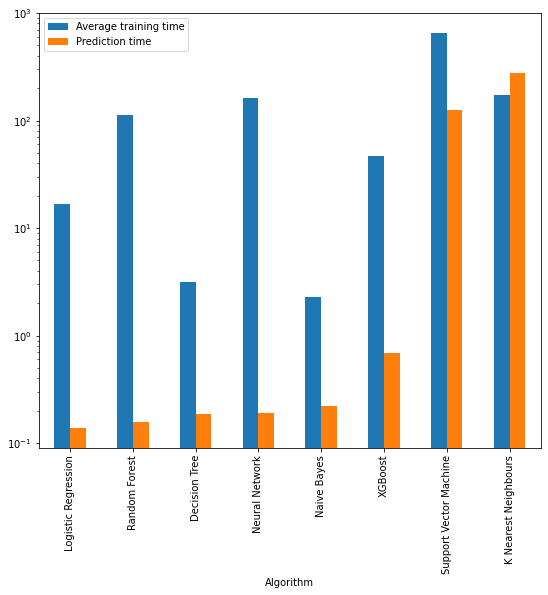

In [161]:
time_df.plot(x="Algorithm", y=["Average training time", "Prediction time"], kind="bar", figsize=(9,8), logy=True)

# Can view the incorrect predictions made by the best model

In [162]:
best_nb.best_params_

{'fit_prior': False, 'class_prior': None, 'alpha': 10}

In [1]:
plot_confusion_matrix(best_knn, X_test, y_test)

NameError: name 'plot_confusion_matrix' is not defined

In [164]:
nb_y_test_pred = best_nb.predict(X_test)

In [165]:
indices = [i for i in range(len(y_test)) if y_test[i] != nb_y_test_pred[i]]

In [166]:
nb_y_test_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [167]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: Label, Length: 2000, dtype: int64

In [168]:
wrong_predictions = test_df.iloc[indices,:]

In [169]:
wrong_predictions

,Sentence,Label
4,"only goalkeeper , roman weidenfeller , fi...",0
6,"they intersex , part group 60 conditions fa...",0
9,"and men , must accept highest mind transcend...",0
15,uk new2 4 1 * * * * * * * * * * ...,0
25,1 million barrels last week,0
...,...,...
1945,insert,1
1952,", @ variable",1
1958,031003000270000,1
1963,uef,1


In [170]:
play_df = pd.DataFrame({'Input': ["Funny Monkey", "105 OR 1=1", "Select * FROM"," \" or ""=\" ", "1*3=3"]})

In [171]:
play_df["Input"] = play_df["Input"].apply(tokenizer)

In [172]:
play_df = cv.transform(play_df["Input"]).toarray()

In [173]:
play_output = best_nb.predict(play_df)

In [174]:
play_output

array([0, 1, 1, 1, 1], dtype=int64)